✅ Loaded merged file: ../data/merged_data.csv
Dataset shape: (3762, 27)
Date range: 2010-03-03 00:00:00 → 2025-03-26 00:00:00


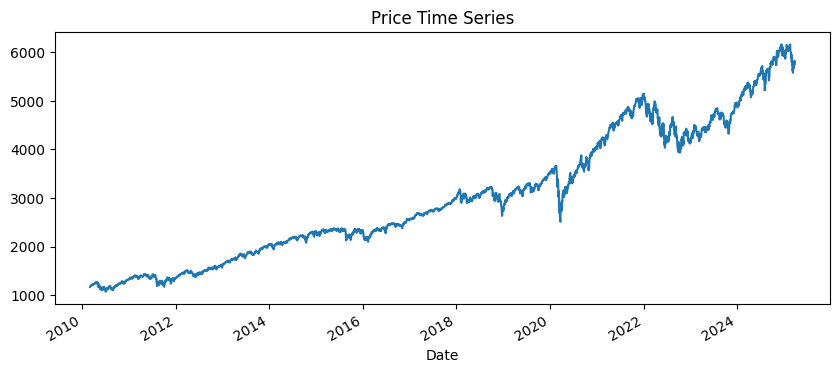

Best ARIMA order by RMSE: (2, 2, 2), RMSE=467.6588, AIC=28222.11
Selected ARIMA RMSE: 467.6587832384571


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def regression_metrics(y_true, y_pred):
    """
    Regression metrics safe for financial time series
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

import os

# Paths (notebook is in: project/notebooks/)
MERGED_PATH = "../data/merged_data.csv"
DATA_PATH = "../data/Data.csv"
STOCK_PATH = "../data/StockPrice.csv"

if os.path.exists(MERGED_PATH):
    df = pd.read_csv(MERGED_PATH, parse_dates=["Date"])
    print(f"✅ Loaded merged file: {MERGED_PATH}")
else:
    raise FileNotFoundError(
        "merged_data.csv not found. "
        "Please run the feature engineering notebook first.",
    )

# Enforce chronological order
df = df.sort_values("Date").reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} → {df['Date'].max()}")


# Set time index
df.set_index("Date", inplace=True)

# Target series
y = df["Price"].astype(float)

# Optional: visualize
y.plot(title="Price Time Series", figsize=(10, 4))
plt.show()


train_size = int(len(y) * 0.8)
y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:]


from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import itertools

warnings.filterwarnings("ignore")

# Grid search over ARIMA(p, d, q) orders
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_order = None
best_aic = np.inf
best_rmse = np.inf

for order in pdq:
    try:
        model = ARIMA(y_train, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=len(y_val))
        rmse = np.sqrt(mean_squared_error(y_val, forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_aic = fit.aic
            best_order = order
    except Exception:
        continue

if best_order is None:
    raise ValueError("No suitable ARIMA model found during grid search.")

print(f"Best ARIMA order by RMSE: {best_order}, RMSE={best_rmse:.4f}, AIC={best_aic:.2f}")

# Refit best model on training data
arima_model = ARIMA(y_train, order=best_order)
arima_fit = arima_model.fit()

# Forecast with selected model
arima_forecast = arima_fit.forecast(steps=len(y_val))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, arima_forecast))
print("Selected ARIMA RMSE:", rmse)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics for ARIMA model
metrics = regression_metrics(y_val, arima_forecast)

# Display metrics
print("=== ARIMA Model - Regression Metrics ===")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

=== ARIMA Model - Regression Metrics ===
MSE: 218704.7375
RMSE: 467.6588
MAE: 408.5377
R2: 0.4346


In [5]:
# SARIMA and SARIMAX comparison
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Seasonal period guess (weekly seasonality on daily data); adjust if needed
SEASONAL_PERIOD = 7

exog_df = df.drop(columns=["Price"], errors="ignore")
exog_df = exog_df.select_dtypes(include=["number"]) if not exog_df.empty else None
exog_train = exog_df.iloc[:train_size] if exog_df is not None else None
exog_val = exog_df.iloc[train_size:] if exog_df is not None else None

p = d = q = range(0, 2)
P = D = Q = range(0, 2)

orders = list(itertools.product(p, d, q))
seasonal_orders = [(P_, D_, Q_, SEASONAL_PERIOD) for P_, D_, Q_ in itertools.product(P, D, Q)]

def evaluate_sarimax(order, seasonal_order, use_exog):
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                    exog=exog_train if use_exog else None, enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)
    forecast = fit.forecast(steps=len(y_val), exog=exog_val if use_exog else None)
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    return rmse, fit

best_sarima = {"order": None, "seasonal_order": None, "rmse": np.inf, "fit": None}
best_sarimax = {"order": None, "seasonal_order": None, "rmse": np.inf, "fit": None}

for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            rmse, fit = evaluate_sarimax(order, seasonal_order, use_exog=False)
            if rmse < best_sarima["rmse"]:
                best_sarima.update(order=order, seasonal_order=seasonal_order, rmse=rmse, fit=fit)
        except Exception:
            continue
        if exog_df is not None:
            try:
                rmse, fit = evaluate_sarimax(order, seasonal_order, use_exog=True)
                if rmse < best_sarimax["rmse"]:
                    best_sarimax.update(order=order, seasonal_order=seasonal_order, rmse=rmse, fit=fit)
            except Exception:
                continue

print(f"Best SARIMA: order={best_sarima['order']}, seasonal={best_sarima['seasonal_order']}, RMSE={best_sarima['rmse']:.4f}")
sarima_forecast = best_sarima["fit"].forecast(steps=len(y_val))
sarima_metrics = regression_metrics(y_val, sarima_forecast)
print("SARIMA metrics:")
for k, v in sarima_metrics.items():
    print(f"  {k}: {v:.4f}")

if exog_df is not None and best_sarimax["fit"] is not None:
    print(f"Best SARIMAX: order={best_sarimax['order']}, seasonal={best_sarimax['seasonal_order']}, RMSE={best_sarimax['rmse']:.4f}")
    sarimax_forecast = best_sarimax["fit"].forecast(steps=len(y_val), exog=exog_val)
    sarimax_metrics = regression_metrics(y_val, sarimax_forecast)
    print("SARIMAX metrics:")
    for k, v in sarimax_metrics.items():
        print(f"  {k}: {v:.4f}")
else:
    print("No exogenous features available; SARIMAX skipped.")

Best SARIMA: order=(1, 1, 0), seasonal=(0, 1, 1, 7), RMSE=470.0630
SARIMA metrics:
  MSE: 220959.1952
  RMSE: 470.0630
  MAE: 409.7189
  R2: 0.4287
Best SARIMAX: order=(1, 0, 0), seasonal=(0, 1, 1, 7), RMSE=372.7337
SARIMAX metrics:
  MSE: 138930.4465
  RMSE: 372.7337
  MAE: 320.4519
  R2: 0.6408
